In [1]:
# updates in v3 new code: have users choose input variables, and automatically calc mean, etc quantities with less user input!
# do this using pandas to simplify the data collection process!! yay!!

# 2/1/23 edit: These scripts work really well and simplify rmw calculations well! the second dataframe is taking a bit 
# too long to create, though :( look into changing the loop to speed it up!

In [1]:
# import...
import numpy as np
import xarray as xr
import os
import matplotlib.pyplot as plt
from matplotlib import cm
import pandas as pd

import warnings
import pandas as pd
from scipy.signal import find_peaks

os.chdir("/Users/etmu9498/research/code/scripts")
import make_plots_new_heights
import make_plots
import tc_metadata
import helper_fns

os.chdir("/Users/etmu9498/research/code/scripts/in-situ-scripts")
import load_in_situ_data

os.chdir("/Users/etmu9498/research/code/scripts/plotting")
import rmw_inner_outer_stats as extra_stats # confidence interval function resides here!

In [2]:
# taken from 'in-situ-scripts/save_in_situ_as_nedcdf.py'
# old function is way too clunky and slow, this one works much better!

def tofloat( dataset):
    # this snippet turns all relevant quantities from strings into floats
    # add more fields here if needed!
    keylist = [ 'time', 'WS.d', 'WD.d', 'UWZ.d', 'ASfmrRainRate.1', 'LATref', 'LONref', 'TAS.d', 'PSURF.d', 
               'HT.d', 'PITCHref', 'ROLLref', 'MR.d', 'HUM_REL.d', 'THETA.d', 'THETAE.d', 'THETAV.d', 'TA.d']
    # create an empty version of the xarray dataset
    datasetnew = dataset.copy()
    datasetnew = datasetnew[ []]

    for key in keylist:
        datasetnew[ key] = dataset[ key].astype( float)
    return datasetnew

In [11]:
######################
# load 2021 in situ data and enter metadata
######################
fl_path = "/Users/etmu9498/research/data/in-situ/"
fl_list = make_plots.load_flight_level( fl_path, print_files=False)

# for this notebook, do this for every case from TC Sam and Ida! 
dataset_numbers = [20, 29] # , 31, 32, 34] # this final dataset looks really bad :( excluded from this analysis! 35]
dates = ['08-29', "09-25"] # , "09-26", "09-27", "09-29"] # , "09-30"]
names = ['Ida', 'Sam'] # , 'Sam', 'Sam', 'Sam']

# new code
# add the automatic variable names to the dataset
auto_vars = [ 'name', 'date', 'pass', 'rmw', 'time'] # always find these variables

# input variables
input_vars = [ 'WS.d', 'UWZ.d', 'ASfmrRainRate.1', 'THETAE.d', 'MR.d', 'TA.d'] # change me!
var_names = [ 'wind_speed', 'w', 'Rain Rate', 'Theta E', 'Mixing Ratio', 'temp']  # change me!

# initialize the dataframe!!
fl_data_totals = pd.DataFrame( )


# load datasets once here to save time / repetition:)
data_list = []
for i in range( len( dataset_numbers)):
    # load data
    data_number = dataset_numbers[ i]
    fl_txt = fl_list[ data_number] # original case: 31
    fl_data = load_in_situ_data.load_in_situ( fl_path, fl_txt)
    dataset = tofloat( fl_data)
    
    data_list.append( dataset)
    print( "Dataset " + str( i) + " loaded")

# print( data_list)

Dataset 0 loaded
Dataset 1 loaded


In [12]:
#############################
# new code
# add the fixed / automatic variables to the dataframe first
#############################
for input_ind in range( len( auto_vars)):
    var_total = []
    
    input_field = auto_vars[ input_ind]
  
    print( 'Variable added: ' + input_field)
    
    # loop through flight days
    for i in range( len( dataset_numbers)):
        dataset = data_list[ i]        
        
        # smooth wind speeds and surface pressures- more realistic peaks
        window = 30 # seconds
        spd_avg = pd.Series( dataset['WS.d']).rolling(window=window, min_periods=1, center=True).mean()

        # test 1: pressure threshold with no eyewall limits
        # find max TC strength from averaged wind fields- all eye passes from this tc
        vmax = np.nanmax( spd_avg)
        # check based on max TC strength
        if vmax > 50:
            # print( "SH case")
            peak_min = 40 # m/s
        else: 
            print( "Weaker case: update if statement for different peak_min behavior!")
            peak_min = 40 # m/s

        # find max vel peaks using the min peak height (defined above) for this intensity
        vpeaks = find_peaks( x=spd_avg, height=peak_min, prominence=10)
   
        pass_counter = 0
        # loop through eyewall passes
        # do step = 2 to skip the second index for each eyewall!
        for vind in range( int( len(vpeaks[0]) / 2 ) ):
            
            ###########################
            ## new code
            ## do different things depending on the input var!
            ###########################
            # quick cases:
            if input_field == 'name':
                var_total.append( names[ i])
            elif input_field == 'date':
                var_total.append( dates[ i])
            elif input_field == 'pass':
                var_total.append( pass_counter)
            
            # longer cases
            elif input_field == 'time':
                left_eyewall_ind = vpeaks[0][ 2* vind]
                right_eyewall_ind = vpeaks[0][2 * vind + 1]

                # find the corresponding times
                ws_ind = np.nanargmin( spd_avg[ left_eyewall_ind:right_eyewall_ind])

                # trim down flight level data for a given field to just the rmw region and append it to the temp variable
                var_total.append( dataset[ auto_vars[ input_ind]] [ left_eyewall_ind : right_eyewall_ind])
                    
            elif input_field == 'rmw':
                left_eyewall_ind = vpeaks[0][ 2* vind]
                right_eyewall_ind = vpeaks[0][2 * vind + 1]

                # find the corresponding times
                ws_ind = np.nanargmin( spd_avg[ left_eyewall_ind:right_eyewall_ind])

                # make an rmw axis stretching from one eyewall to the other!
                # they will have an unequal number of data points to conserve the time axis :)
                len1 = ws_ind
                len2 = right_eyewall_ind - ( left_eyewall_ind + ws_ind)
                var_total.append( np.concatenate( [ np.linspace( -1, 0, num=len1, endpoint=False), np.linspace( 0, 1, num=len2) ] ))
            pass_counter += 1    
    # add new columns to the dataframe!
    fl_data_totals[ auto_vars[ input_ind]] = var_total

    

####################
# new code
# repeat this step for every chosen variable in the input list!
# add a new column to the dataframe for each input variable
####################
for input_ind in range( len( input_vars)):

    # total variable that saves individual runs for each tc
    # if there are 3 eye passes for 2 storms, var_total = [ [ temps], [temps2], [temps3] ]
    var_total = []
    
    input_field = input_vars[ input_ind]
  
    print( 'Variable added: ' + input_field)
    
    # loop through flight days
    for i in range( len( dataset_numbers)):
        dataset = data_list[ i]

        # smooth wind speeds and surface pressures- more realistic peaks
        window = 30 # seconds
        spd_avg = pd.Series( dataset['WS.d']).rolling(window=window, min_periods=1, center=True).mean()

        # test 1: pressure threshold with no eyewall limits
        # find max TC strength from averaged wind fields- all eye passes from this tc
        vmax = np.nanmax( spd_avg)
        # check based on max TC strength
        if vmax > 50:
            # print( "SH case")
            peak_min = 40 # m/s
        else: 
            print( "Weaker case: update if statement for different peak_min behavior!")
            peak_min = 40 # m/s

        # find max vel peaks using the min peak height (defined above) for this intensity
        vpeaks = find_peaks( x=spd_avg, height=peak_min, prominence=10)

        
        pass_counter = 0
        # loop through eyewall passes
        # do step = 2 to skip the second index for each eyewall!
        for vind in range( int( len(vpeaks[0]) / 2 ) ):


            left_eyewall_ind = vpeaks[0][ 2* vind]
            right_eyewall_ind = vpeaks[0][2 * vind + 1]

            # find the corresponding times
            ws_ind = np.nanargmin( spd_avg[ left_eyewall_ind:right_eyewall_ind])

            # make an rmw axis stretching from one eyewall to the other!
            # they will have an unequal number of data points to conserve the time axis :)
            len1 = ws_ind
            len2 = right_eyewall_ind - ( left_eyewall_ind + ws_ind)

            # trim down flight level data for a given field to just the rmw region
            # and append it to the temp variable
            var_total.append( dataset[ input_vars[ input_ind]] [ left_eyewall_ind : right_eyewall_ind])         
            pass_counter += 1    

    # add new column to the dataframe!
    fl_data_totals[ var_names[ input_ind]] = var_total


Variable added: name
Variable added: date
Variable added: pass
Variable added: rmw
Variable added: time
Variable added: WS.d
Variable added: UWZ.d
Variable added: ASfmrRainRate.1
Variable added: THETAE.d
Variable added: MR.d
Variable added: TA.d


In [13]:
#####################
# testing
#####################

ind = 0
print( fl_data_totals['name'][ind])
print( len(fl_data_totals['time'][ind].values))
print( len(fl_data_totals['rmw'][ind]))
print( len(fl_data_totals['wind_speed'][ind].values))
print( len(fl_data_totals['w'][ind].values))

# print( fl_data_totals['wind_speed'][ind])

# print( fl_data_totals.shape)
# fl_data_totals

########################
# old
#########################

# only add index names once! check if this is the first time
# append index names onto this list as they're created!
# index_names = []
# if input_ind == 0:
#     index_names.append( dates[ i] + '-pass-' + str(pass_counter))
    
# trying to change the indices to no avail...
# i kinda gave up lol and just added the indices as a separate column!
# fl_data_totals = fl_data_totals.rename( index={index_names})
# fl_data_totals = pd.DataFrame( fl_data_totals, index=index_names)
# print( temp_total)

# df = pd.DataFrame( temp_total)

# with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
#     print(df)

# display(df)

# df = pd.DataFrame( index=dates, columns=columns)
# df

Ida
290
290
290
290


Number of TC flight days = 2
Total number of passes = 5


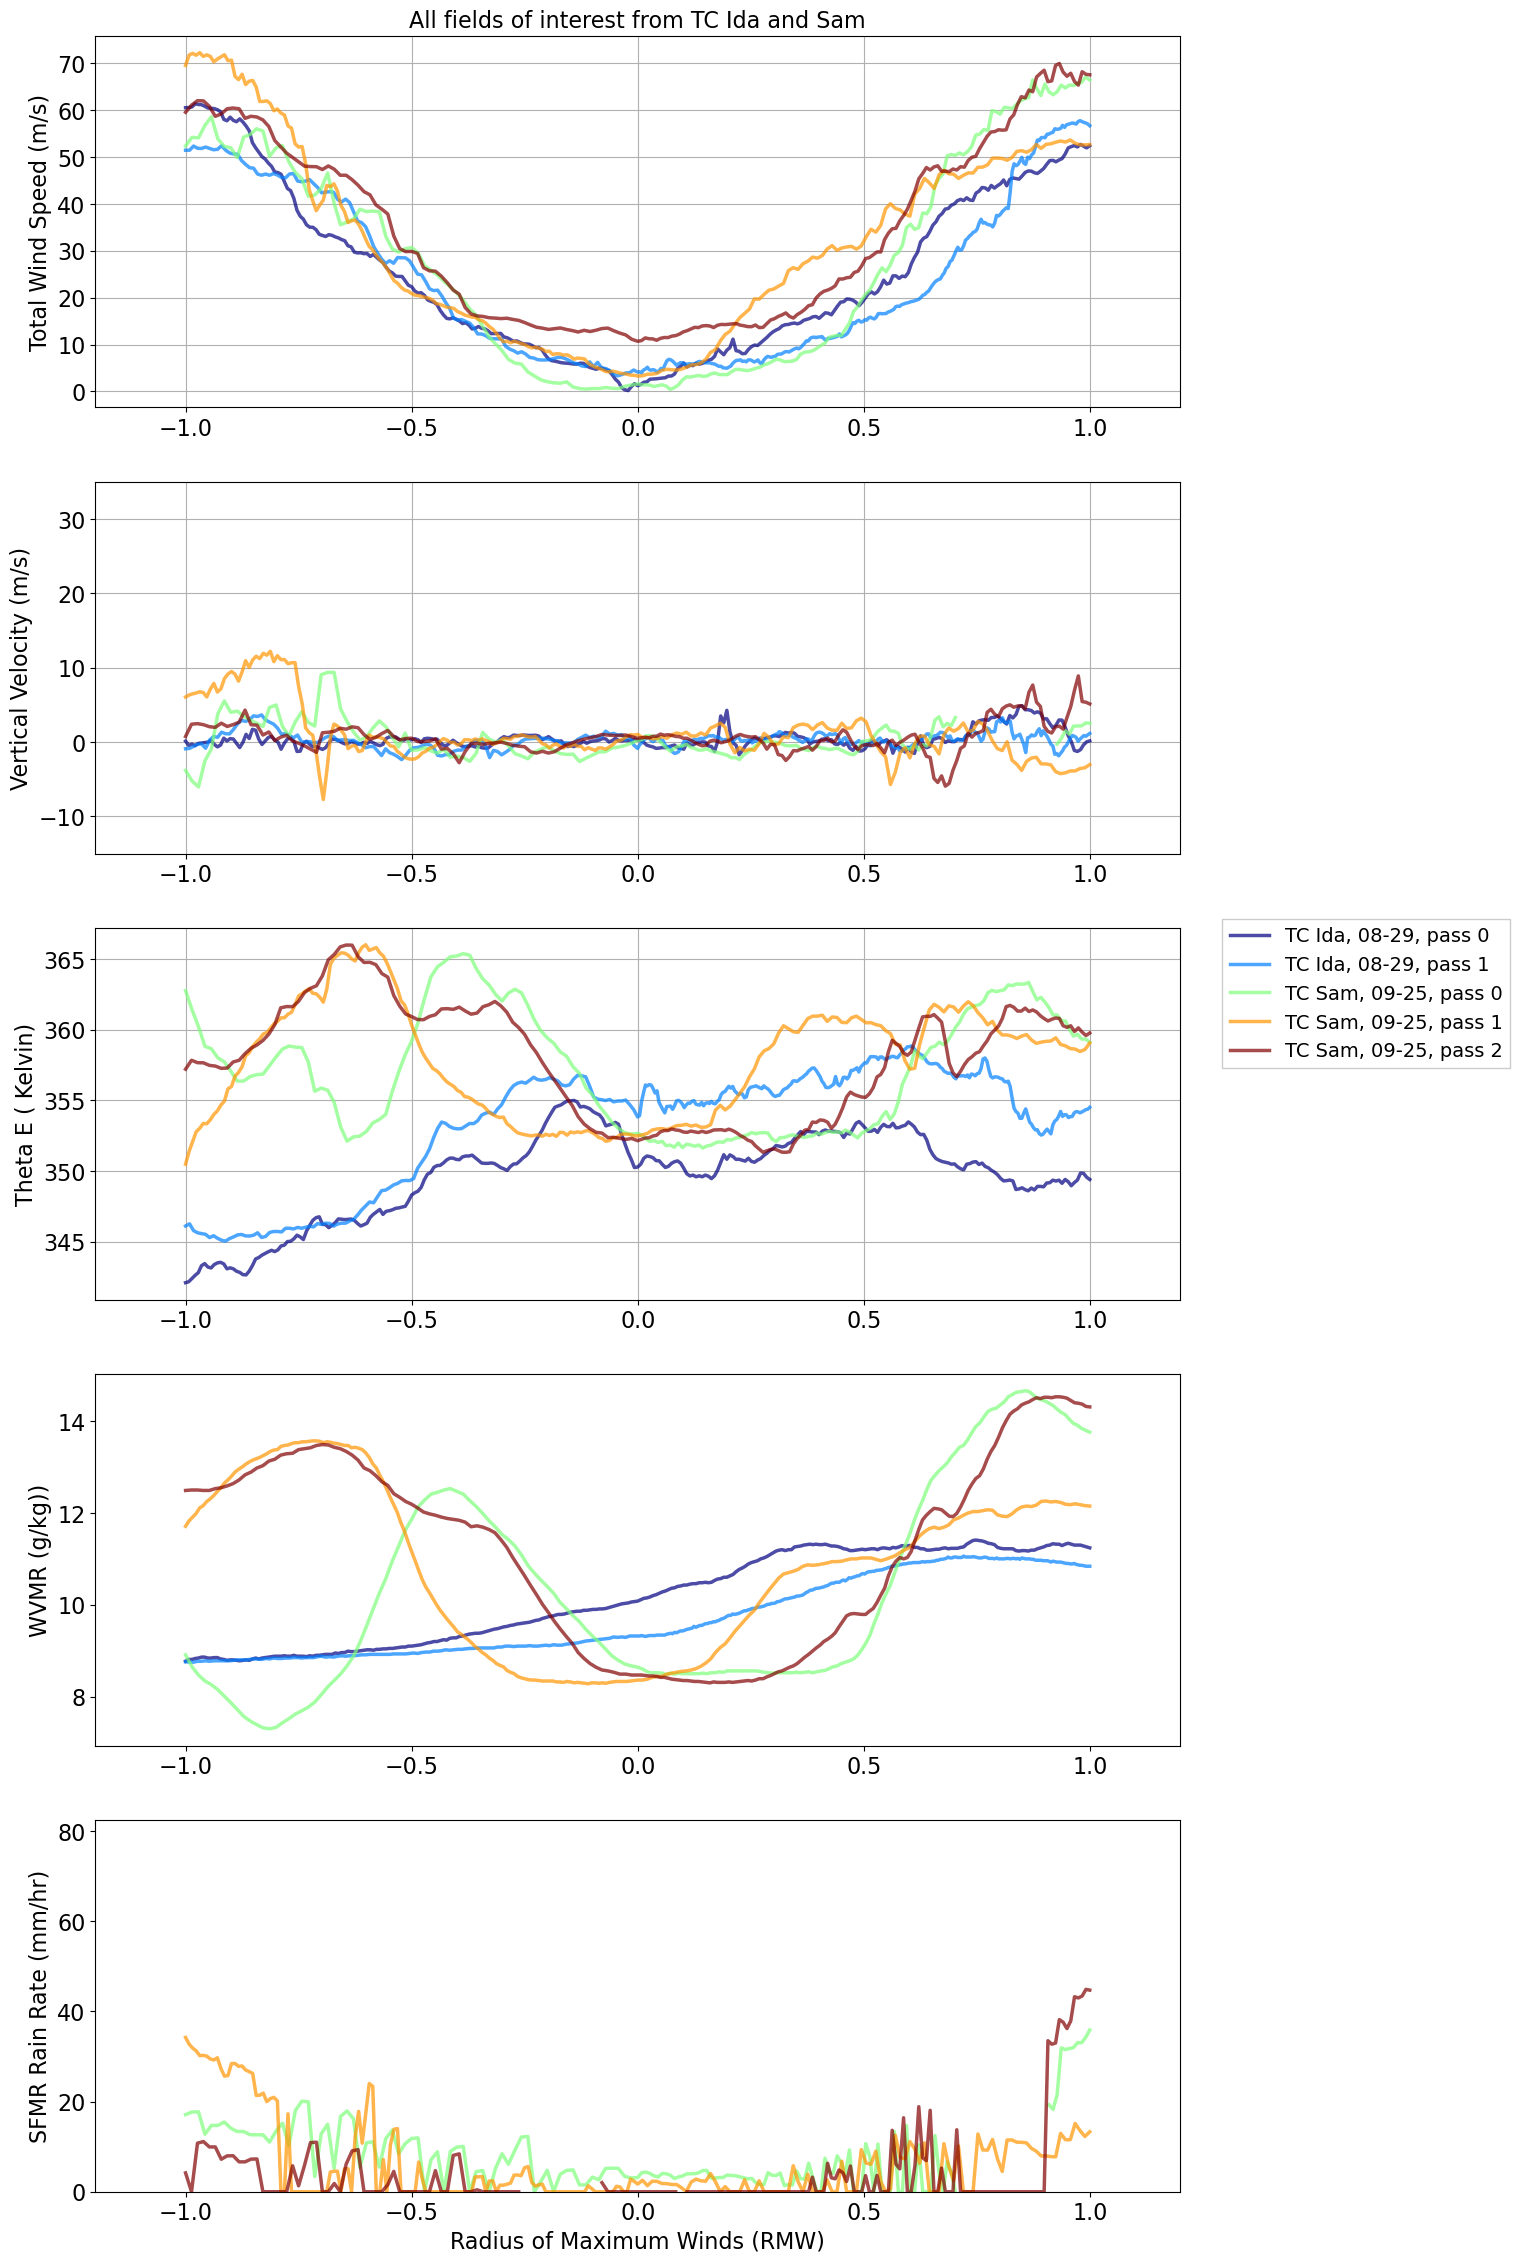

In [15]:
######################
## Make a nice rmw plot for each eye pass!
######################

# make figure before loop and add to it!
plt.figure( figsize=(14, 28))
lw = 2.5
helper_fns.change_font_sizes(16, 16)

plt.subplot(511)
plt.title( "All fields of interest from TC Ida and Sam")
plt.ylabel("Total Wind Speed (m/s)")
plt.xlim( [-1.2, 1.2])  
plt.grid()
plt.subplot(512)
plt.ylabel("Vertical Velocity (m/s)")
plt.xlim( [-1.2, 1.2])
plt.ylim( [-15, 35])
plt.grid()
plt.subplot( 513)
plt.ylabel("Theta E ( Kelvin)")
plt.xlim( [-1.2, 1.2])
plt.subplot(514)
plt.ylabel("WVMR (g/kg))")
plt.xlim( [-1.2, 1.2])
plt.subplot(515)
plt.ylabel("SFMR Rain Rate (mm/hr)")
plt.xlabel("Radius of Maximum Winds (RMW)")
plt.ylim( [0, 82.5])
plt.xlim( [-1.2, 1.2])


# create a colormap for nice plotting!
start = 0.0
stop = 1.0
number_of_lines= fl_data_totals.shape[0]

cm_subsection = np.linspace(start, stop, number_of_lines) 
colors = [ cm.jet(x) for x in cm_subsection ]


# do this for every flight date in this case (defined in code block above)
print( "Number of TC flight days = " + str( len( dataset_numbers)))
print( 'Total number of passes = ' + str( number_of_lines))

# cycle through each row in the dataframe
for i in range( number_of_lines):
    # make plots of total wind speed and vertical vels along new rmw axes!
    plt.subplot(511)
    plt.plot( fl_data_totals['rmw'][i], fl_data_totals['wind_speed'][i], c=colors[ i], linewidth=lw, alpha=.7)
                
    plt.subplot(512)
    plt.plot( fl_data_totals['rmw'][i], fl_data_totals['w'][i], c=colors[ i], linewidth=lw, alpha=.7)

    plt.subplot(513)
    label = "TC " + fl_data_totals['name'][i] + ", " + fl_data_totals['date'][i] + ", pass " + str( fl_data_totals['pass'][i])
    plt.plot( fl_data_totals['rmw'][i], fl_data_totals['Theta E'][i], c=colors[ i], label=label, linewidth=lw, alpha=.7)

    if i == number_of_lines - 1:
        plt.legend( bbox_to_anchor=(1.03, 1.05), fancybox=False, shadow=False, fontsize=14, facecolor='w', framealpha=1)
        plt.grid()
        
    plt.subplot(514)
    plt.plot( fl_data_totals['rmw'][i], fl_data_totals['Mixing Ratio'][i], c=colors[ i], linewidth=lw, alpha=.7)
        
    plt.subplot(515)
    plt.plot( fl_data_totals['rmw'][i], fl_data_totals['Rain Rate'][i], c=colors[ i], linewidth=lw, alpha=.7)
                

In [7]:
##############################
## new code
## make a new data array to hold binned rmw axis and values!
##############################

# initialize the dataframe!!
df_binned = pd.DataFrame( )

# bin_list = ['rmw', 'time'] + input_vars
bin_names = ['rmw', 'time'] + var_names

In [8]:
# pick a bin width for rmw values, sort velocities into those bins, and 
# calculate important quantities like the mean, standard deviation, and confidence levels! 

### important! instead of going from -1 < RMW < 1, sort from 0 to 1! the negative distinction doesn't matter here
# setup steps

# .005 is an interesting bin width! anything larger than .01 lacks resolution, smaller than .005 is too noisy
binwidth = .01 # bin width from 0 to 1

# make an array representing the bins! 
bins = np.arange(0, 1.00001, step=binwidth)

# create an array of midpoints (right between two given binwidths)
# will be 1 val shorter than bins array
# used for plotting later
midpoints = []
for i in range( len( bins) - 1):
    midpoints.append( (bins[ i] + bins[ i+1]) / 2)

# print( bins)
# print( midpoints)


# add midpoints and bins to the data array
df_binned[ 'bins'] = bins[ 0: len( bins)-1] # drop last value for correct array size
df_binned[ 'midpoints'] = midpoints

df_binned

bins  midpoints
0   0.00      0.005
1   0.01      0.015
2   0.02      0.025
3   0.03      0.035
4   0.04      0.045
..   ...        ...
95  0.95      0.955
96  0.96      0.965
97  0.97      0.975
98  0.98      0.985
99  0.99      0.995

[100 rows x 2 columns]

In [27]:
# loop steps: actually do the averaging, etc!

# do this for every variable saved in the bin list above
for var_i in range( len( bin_names)):

    input_field = bin_names[ var_i]
    print( 'Variable added: ' + input_field)

    # this variable holds the sorted contents for each input field!
    sorted_var = []
    for i in range( len( bins) - 1):
        sorted_var.append( [])
    
    data_field = fl_data_totals[ input_field ].values
    
    # do this for every pass in the dataframe
    for pass_i in range( fl_data_totals.shape[0]):

        # print( 'pass ' + str(pass_i))
        
        # sort through every rmw axis value for a given eye pass: check if it's within the bin!
        for rmw_i in range( len( fl_data_totals['rmw'][pass_i] )):

            # locally define the current value for convenience :)
            rmw_val = fl_data_totals['rmw'][ pass_i][rmw_i]
    
            # print( 'rmw val: ' + str( rmw_val))
            
            # sort through the bins
            # -1 to account for two bins being chosen in the beginning
            for bin_i in range( len( bins) - 1):

                # check if the current rmw value is within this bin!
                bin_val_i = bins[ bin_i]
                bin_val_next = bins[ bin_i + 1]

                ##############
                # important!
                # maybe round to the 2nd or 3rd decimal place for this step?

                if ( rmw_val >= bin_val_i and rmw_val < bin_val_next) or (- rmw_val >= bin_val_i and - rmw_val < bin_val_next):
                   
                    # append the values to the sorted list
                    # rmw values are already floats, other vars need to use .values to switch from xarray to floats!
                    if input_field != 'rmw':
                        sorted_var[ bin_i].append( data_field[pass_i][rmw_i].values )
                    else:
                        sorted_var[ bin_i].append( data_field[pass_i][rmw_i] )
                        
    # after going through every pass for this variable, add the results to the dataframe!
    df_binned[ bin_names[ var_i ] + "_array"] = sorted_var


Variable added: rmw
Variable added: time
Variable added: wind_speed
Variable added: w
Variable added: Rain Rate
Variable added: Theta E
Variable added: Mixing Ratio
Variable added: temp


In [28]:
confidence=.99
    
# do this for every variable
for var_i in range( len( bin_names)):
    var_mean, var_lowc, var_highc = [], [], []
    
    field = df_binned[ bin_names[ var_i] + "_array"]
    
    # do this for every bin for that variable
    for i in range( len( df_binned[ 'midpoints'] )):
        mean, lowc, highc = extra_stats.mean_confidence_interval( 
                    np.ma.masked_array( field[ i], np.isnan( field[ i])), confidence=confidence)
        var_mean.append(  mean)
        var_lowc.append(  lowc)
        var_highc.append(  highc)

    # after going through every pass for this variable, add the results to the dataframe!
    df_binned[ bin_names[ var_i] + "_mean"] = var_mean
    df_binned[ bin_names[ var_i] + "_highc"] = var_highc
    df_binned[ bin_names[ var_i] + "_lowc"] = var_lowc
    
    print( "Confidence intervals found for " + bin_names[ var_i])


Confidence intervals found for rmw
Confidence intervals found for time
Confidence intervals found for wind_speed
Confidence intervals found for w
Confidence intervals found for Rain Rate
Confidence intervals found for Theta E
Confidence intervals found for Mixing Ratio
Confidence intervals found for temp


In [29]:
df_binned.columns

Index(['bins', 'midpoints', 'rmw_array', 'time_array', 'wind_speed_array',
       'w_array', 'Rain Rate_array', 'Theta E_array', 'Mixing Ratio_array',
       'temp_array', 'rmw_mean', 'rmw_highc', 'rmw_lowc', 'time_mean',
       'time_highc', 'time_lowc', 'wind_speed_mean', 'wind_speed_highc',
       'wind_speed_lowc', 'w_mean', 'w_highc', 'w_lowc', 'Rain Rate_mean',
       'Rain Rate_highc', 'Rain Rate_lowc', 'Theta E_mean', 'Theta E_highc',
       'Theta E_lowc', 'Mixing Ratio_mean', 'Mixing Ratio_highc',
       'Mixing Ratio_lowc', 'temp_mean', 'temp_highc', 'temp_lowc'],
      dtype='object')

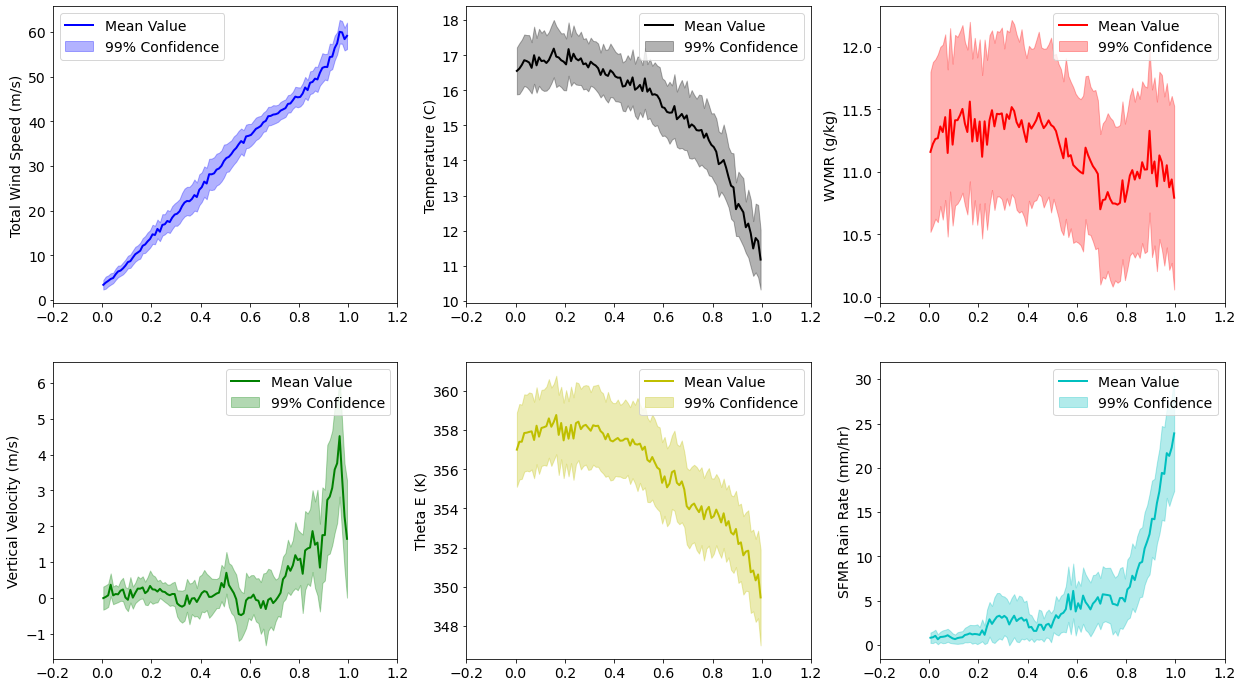

In [30]:
# make figure 
plt.figure( figsize=(21, 12))
lw = 2.
helper_fns.change_font_sizes(14, 14)

# make plots of total wind speed and vertical vels along new rmw axes!
plt.subplot(231)

subplots = [ 231, 232, 233, 234, 235, 236]
ylabels = [ "Total Wind Speed (m/s)", "Temperature (C)", "WVMR (g/kg)", "Vertical Velocity (m/s)", "Theta E (K)", 
          "SFMR Rain Rate (mm/hr)"]
colors = ['b', 'k', 'r', 'g', 'y', 'c']

# use the var_names list defined way earlier for plotting!
new_var_names = ['wind_speed', 'temp', 'Mixing Ratio', 'w', 'Theta E', 'Rain Rate' ]

for i in range( len( subplots)):

    plt.subplot( subplots[ i])
    plt.ylabel(ylabels[ i])
    plt.xlim( [-.2, 1.2])
    plt.plot( df_binned[ 'midpoints'], df_binned[ new_var_names[ i] + '_mean'], c=colors[i], linewidth=lw, label="Mean Value")

    ax = plt.gca()
    ax.fill_between( df_binned[ 'midpoints'], df_binned[ new_var_names[ i] + '_lowc'], df_binned[ new_var_names[ i] + '_highc'],
                    color=colors[i], alpha=0.3, label=str( int(confidence*100)) + "% Confidence")
    ax.legend()